# SARIMA with eXogenous data (SARIMAX)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import warnings
import math
import itertools
warnings.filterwarnings("ignore")

#Prepare Data

In [17]:
!wget 'https://github.com/kaopanboonyuen/2110446_DataScience_2021s2/raw/main/datasets/PM25dataset/Bangkok.txt'

--2022-02-11 01:49:07--  https://github.com/kaopanboonyuen/2110446_DataScience_2021s2/raw/main/datasets/PM25dataset/Bangkok.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kaopanboonyuen/2110446_DataScience_2021s2/main/datasets/PM25dataset/Bangkok.txt [following]
--2022-02-11 01:49:07--  https://raw.githubusercontent.com/kaopanboonyuen/2110446_DataScience_2021s2/main/datasets/PM25dataset/Bangkok.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 763228 (745K) [text/plain]
Saving to: ‘Bangkok.txt.1’

Bangkok.txt.1       100%[===================>] 745.34K  --.-KB/s    in 0.05s   

2022-02-11 

In [18]:
with open('Bangkok.txt','r') as f:
    for i in range(12):
        print(f.readline())

% Country: Thailand

% City: Bangkok

% City (ASCII): Bangkok

% Region: Bangkok

% Region (ASCII): Bangkok

% Population: 5104476

% Latitude: 13.754

% Longitude: 100.5014

% Time Zone: Asia/Bangkok

% Year, Month, Day, UTC Hour, PM2.5, PM10_mask, Retrospective

2016	3	3	8	62.9	1.00	0

2016	3	3	9	62.9	1.00	0



In [19]:
bkk_pm25 = pd.read_csv('Bangkok.txt', sep='\t', header=None, skiprows=10)
bkk_pm25

,0,1,2,3,4,5,6
0,2016,3,3,8,62.9,1.0,0
1,2016,3,3,9,62.9,1.0,0
2,2016,3,3,10,55.5,1.0,0
3,2016,3,3,11,55.5,1.0,0
4,2016,3,3,12,47.9,1.0,0
...,...,...,...,...,...,...,...
31141,2020,3,18,9,23.9,0.0,0
31142,2020,3,18,10,24.4,0.0,0
31143,2020,3,18,11,24.9,0.0,0
31144,2020,3,18,12,27.0,0.0,0


In [20]:
bkk_pm25['Time'] = pd.to_datetime({'year': bkk_pm25[0], 'month': bkk_pm25[1], 'day':bkk_pm25[2],'hour': bkk_pm25[3]})

bkk_pm25['Time'] = bkk_pm25['Time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
bkk_pm25['Time'] = bkk_pm25['Time'].dt.tz_localize(None)

bkk_pm25=bkk_pm25.drop([0,1,2,3,5,6],axis=1)
bkk_pm25.columns = ['PM2.5(µg/m3)', 'Time']
bkk_pm25 = bkk_pm25.set_index('Time')

bkk_pm25

,PM2.5(µg/m3)
Time,
2016-03-03 15:00:00,62.9
2016-03-03 16:00:00,62.9
2016-03-03 17:00:00,55.5
2016-03-03 18:00:00,55.5
2016-03-03 19:00:00,47.9
...,...
2020-03-18 16:00:00,23.9
2020-03-18 17:00:00,24.4
2020-03-18 18:00:00,24.9


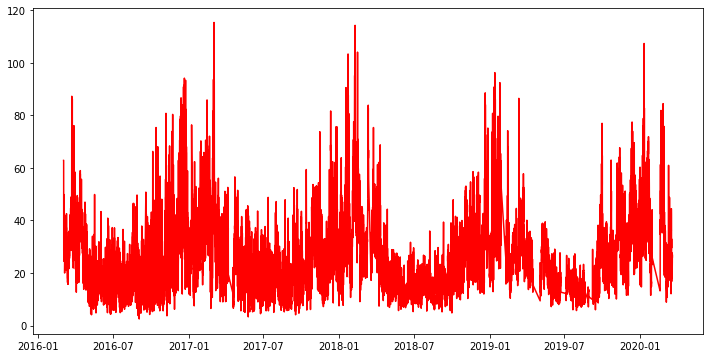

In [21]:
bkk_pm25 = bkk_pm25[~bkk_pm25.index.duplicated(keep='first')]
bkk_pm25.index = pd.DatetimeIndex(bkk_pm25.index)
bkk_pm25 = bkk_pm25.reindex(pd.date_range("2016-03-03 15:00:00", "2020-03-18 20:00:00",freq='h'), fill_value=np.nan)
bkk_pm25 = bkk_pm25.interpolate()

plt.figure(figsize=(12,6))
plt.plot(bkk_pm25,'r')

In [22]:
temp_df = pd.read_csv('https://github.com/kaopanboonyuen/2110446_DataScience_2021s2/raw/main/datasets/PM25dataset/3H_temperature_Bangkok.csv')
temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])
temp_df.set_index(temp_df['datetime'],inplace=True)
temp_df.drop(columns={'datetime'},inplace=True)
temp_df = temp_df.resample('h').ffill()

In [23]:
temp_df

,Temp(C),lat,long
datetime,,,
2016-01-01 01:00:00,24.8,13.754,100.5014
2016-01-01 02:00:00,24.8,13.754,100.5014
2016-01-01 03:00:00,24.8,13.754,100.5014
2016-01-01 04:00:00,23.8,13.754,100.5014
2016-01-01 05:00:00,23.8,13.754,100.5014
...,...,...,...
2020-12-31 18:00:00,29.6,13.754,100.5014
2020-12-31 19:00:00,26.4,13.754,100.5014
2020-12-31 20:00:00,26.4,13.754,100.5014


In [24]:
data = bkk_pm25.merge(temp_df,left_index=True,right_index=True)

In [25]:
data[['PM2.5(µg/m3)','Temp(C)']]

,PM2.5(µg/m3),Temp(C)
2016-03-03 15:00:00,62.9,34.1
2016-03-03 16:00:00,62.9,34.6
2016-03-03 17:00:00,55.5,34.6
2016-03-03 18:00:00,55.5,34.6
2016-03-03 19:00:00,47.9,29.1
...,...,...
2020-03-18 16:00:00,23.9,33.0
2020-03-18 17:00:00,24.4,33.0
2020-03-18 18:00:00,24.9,33.0
2020-03-18 19:00:00,27.0,30.4


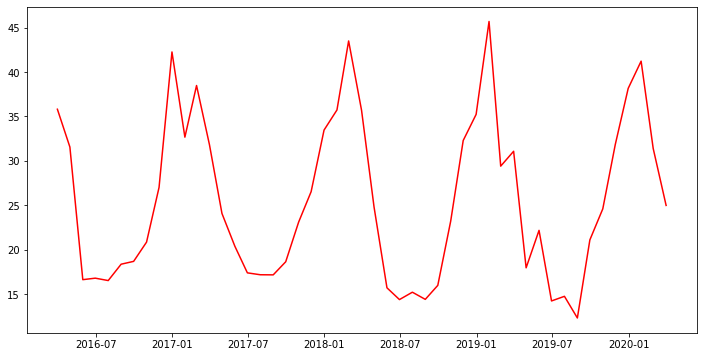

In [26]:
data = data.resample('M').mean()
plt.figure(figsize=(12,6))
plt.plot(data['PM2.5(µg/m3)'],'r')

#Split data

In [27]:
data.head()

,PM2.5(µg/m3),Temp(C),lat,long
2016-03-31,35.814905,30.238620,13.754,100.5014
2016-04-30,31.561806,32.025000,13.754,100.5014
2016-05-31,16.634745,31.756855,13.754,100.5014
2016-06-30,16.803264,30.157778,13.754,100.5014
2016-07-31,16.533401,29.157258,13.754,100.5014


In [28]:
train_size, valid_size, test_size = map(lambda r: int(r*data.shape[0]), (0.6, 0.2, 0.2))

train, valid, test = data.iloc[:train_size], data.iloc[train_size: train_size + valid_size], data.iloc[train_size + valid_size:]

In [29]:
exog_columns = ['Temp(C)']

#Fit model with exogenous data
We use the best parameter from the previous lab

In [30]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [31]:
best_order = (0, 1, 1)
best_seasonal_order = (1, 1, 0, 12)

In [32]:
mod = SARIMAX(train['PM2.5(µg/m3)'],
              exog=train[exog_columns],
              order=best_order,
              seasonal_order=best_seasonal_order,
              enforce_stationarity=False,
              enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp(C)        3.4119      1.302      2.621      0.009       0.861       5.963
ma.L1          1.0000   1.77e+05   5.66e-06      1.000   -3.47e+05    3.47e+05
ar.S.L12      -0.5528      0.139     -3.971      0.000      -0.826      -0.280
sigma2         1.1090   1.96e+05   5.66e-06      1.000   -3.84e+05    3.84e+05


#Predict on test
Even if it only predicts on the test set, it needs exogenous data in both validation set and test set to continuously make predictions in sequence from training set to validation set and, finally, to test set.<br>
So, here, we concatenate exogenous data in validation set and test set together.

In [33]:
test_exog = pd.concat((valid[exog_columns], test[exog_columns]), axis=0)

In [34]:
pred = results.get_prediction(start=test.index[0], end=test.index[-1], exog=test_exog, dynamic=False)
pred_ci = pred.conf_int()

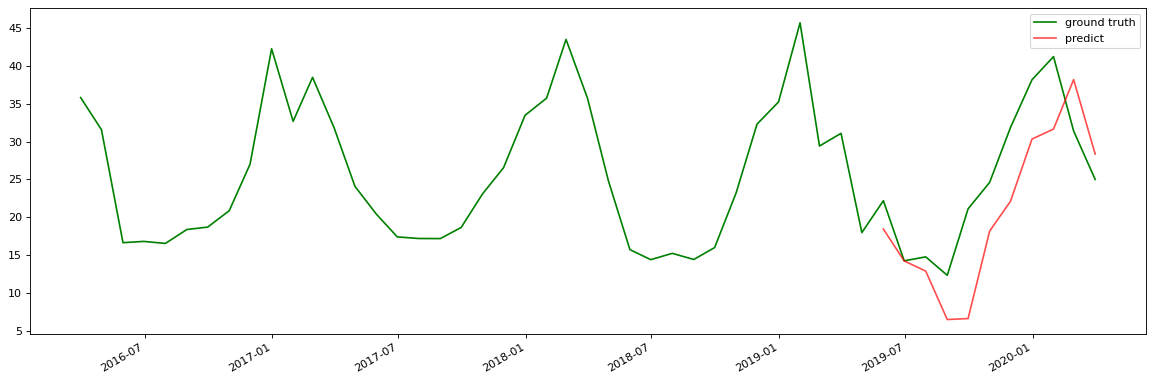

In [35]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data['PM2.5(µg/m3)'], color='g',label='ground truth')
pred.predicted_mean.plot(alpha=.7, color='r',label='predict')
plt.legend(loc="upper right")

plt.show()

In [36]:
mse = mean_squared_error(test['PM2.5(µg/m3)'], pred.predicted_mean)
rmse = math.sqrt(mse)
print('Test on SARIMAX with RMSE: %f' % (rmse, ))

Test on SARIMAX with RMSE: 7.439540
